In [1]:
library(caret)
library(car)
library(pscl)
library(ROCR)
library(pROC)
library(glmnet)
library(plotmo)
library(randomForest)
library(varSelRF)
library(MASS)
library(ggplot2)
library(ggthemes)
library(RColorBrewer)
library(Rmisc)
set.seed(416)


Loading required package: lattice
Loading required package: ggplot2
Loading required package: carData
Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: 'glmnet'

The following object is masked from 'package:pROC':

    auc

Loading required package: plotrix

Attaching package: 'plotrix'

The following object is masked from 'package:gplots':

    plotCI

Loading required package: TeachingDemos
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes

### Load and Filter Data

In [2]:
wk1<-read.csv("Intermediate-Data/Week_1_data.csv", stringsAsFactors = F)
wk1$dup1<-duplicated(wk1$Username, fromLast=F)
wk1<-subset(wk1, !is.na(LabSection))
wk1<-subset(wk1, dup1!=TRUE)

In [3]:
reg<-read.csv("Intermediate-Data/RegistrarData.csv", stringsAsFactors = F)

In [4]:
data<-merge(wk1, reg, by = "Username", all.y = T)
datasave<-data
rm(reg,wk1)

In [5]:
data$Cal1WVUCount<-ifelse(data$Cal1WVUCount > 1, 1, 0)
data$P111WVUCount<-ifelse(data$P111WVUCount > 1, 1, 0)
data$GenderNum<-ifelse(data$Gender == "M", 1, 0)
data$FinalCourseGradeAB_Rest2<-ifelse(data$FinalCourseGradeAB_Rest == "AB",1,0)

In [6]:
data<-subset(data, !is.na(HSGPA))
data<-subset(data, !is.na(ACTSATM))

### Constructing New Variables

In [7]:
lecQs<-grep(".*(LecQ).", names(data))
labQs<-grep(".*(LabQ).", names(data))
labs<-grep(".*(Lab\\d).*", names(data))
Fhwks<-grep(".*(FHwk).", names(data))
LecMiss<-grep(".*(Lec)\\d(Miss).*", names(data))
LabMiss<-grep(".*(Lab)\\d(Miss).*", names(data))
Sbonus<-grep(".*(SBonus)\\d.*", names(data))
labs<-setdiff(labs, LabMiss)

data$LecQGrade<-rowMeans(subset(data, select = lecQs), na.rm = T)
data$LecQGrade<-ifelse(is.na(data$LecQGrade), 0, data$LecQGrade)
data$LabQGrade<-rowMeans(subset(data, select = labQs), na.rm = T)
data$LabQGrade<-ifelse(is.na(data$LabQGrade), 0, data$LabQGrade)
data$LabGrade<-rowMeans(subset(data, select = labs), na.rm = T)
data$LabGrade<-ifelse(is.na(data$LabGrade), 0, data$LabGrade)
data$HWGrade<-rowMeans(subset(data, select = Fhwks), na.rm = T)
data$HWGrade<-ifelse(is.na(data$HWGrade), 0, data$HWGrade)
data$MissLect<-rowSums(subset(data, select = LecMiss), na.rm = T)
data$MissLab<-rowSums(subset(data, select = LabMiss), na.rm = T)
data$MissAnyLectures<-ifelse(data$MissLect > 0, "Y","N")
data$MissAnyLabs<-ifelse(data$MissLab > 0, "Y","N")
data$BonusPoints<-rowMeans(subset(data, select = Sbonus), na.rm = T)
data$BonusPoints<-ifelse(is.na(data$BonusPoints), 0, data$BonusPoints)
data$BonusPointsTot<-rowSums(subset(data, select = Sbonus), na.rm = T)
data$BonusPointsTot<-ifelse(is.na(data$BonusPointsTot), 0, data$BonusPointsTot)


data$MathEntry<-as.factor(data$MathEntry)

### Building the Test and Training Dataset

In [8]:
#train_index <- sample(1:nrow(data), 0.63 * nrow(data))
#test_index <- setdiff(1:nrow(data), train_index)

#write.csv(train_index,"Intermediate-Data/train_index.csv", row.names = F)
#write.csv(test_index,"Intermediate-Data/test_index.csv", row.names = F)
trI<-as.vector(read.csv("Intermediate-Data/train_index.csv", stringsAsFactors = F))
teI<-as.vector(read.csv("Intermediate-Data/test_index.csv", stringsAsFactors = F))
train_index<-trI[,1]
test_index<-teI[,1]

train<-data[train_index,]
test<-data[test_index,]

TestActual<-ifelse(test$FinalCourseGradeAB_Rest == "AB", 1,0)

### Baseline Model

Warning message in confusionMatrix.default(data = as.factor(ZeroRulePred), reference = as.factor(TestActual)):
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         

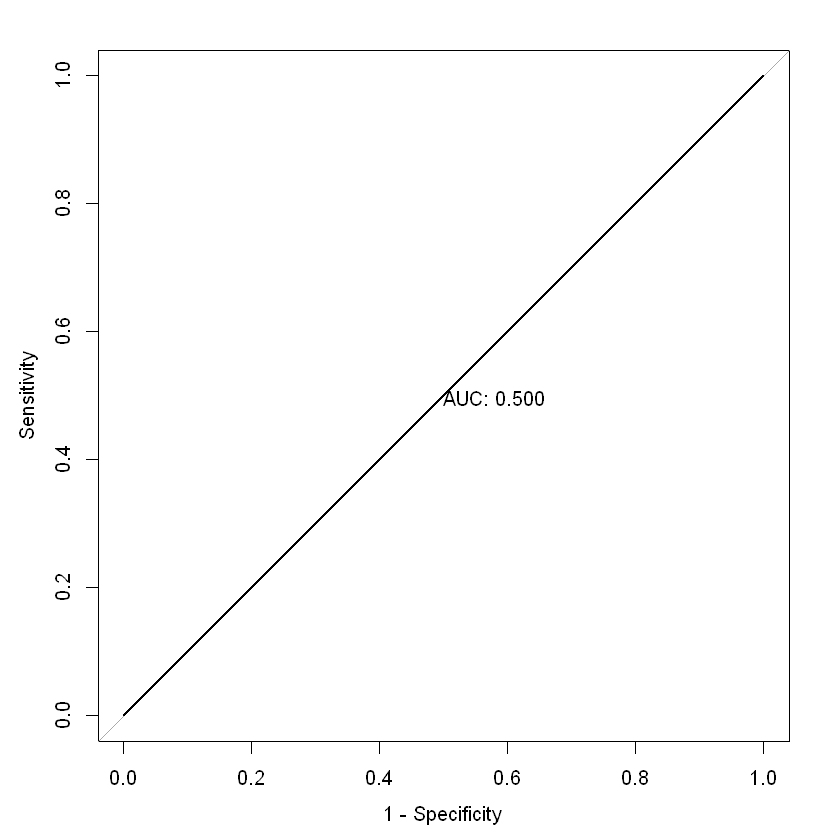

In [9]:
ZeroRulePred<-rep(1,297)

confusionMatrix(data = as.factor(ZeroRulePred), reference = as.factor(TestActual))

ZR.Roc<-roc(TestActual, ZeroRulePred)
plot.roc(ZR.Roc, print.thres = F, print.auc = T, legacy.axes = T)

### Logistic Modeling

#### Univariate Models

In [10]:
sink("Output Text/Univariate Registrar Logistic Models.txt")
lapply(c("P111LastGradeAB_Rest" , "P111WVUCount" , "P112FirstAttempt" ,"CURGPA" , "HSGPA" , "ACTSATM",
         "ACTSATV","Cal1LastGradeAB_Rest","Cal1WVUCount","CUREnroll","CURAZcount","CURCred","APCount",
         "APCredit","TransferCount","TransferCredit","IsFirstFall","IsFirstGen","MathEntry","CURCMP","GenderNum"),
       #lapply(c("CSEMPretestPercent" ),      
       function(var) {
         
         formula    <- as.formula(paste("as.factor(FinalCourseGradeAB_Rest2) ~", var))
         res.logist <- glm(formula, data = train, family = "binomial")
         
         print(summary(res.logist))
         print(pR2(res.logist))
         pred<-predict(res.logist, newdata = test, type = 'response')
         print(confusionMatrix(data = as.factor(as.numeric(pred>0.5)), reference = as.factor(TestActual)))
         roc.mod<-roc(TestActual, pred)
        # cat("AUC: ",auc(roc.mod), "\n")
         cat("AUC CI: ", ci.auc(roc.mod),"\n")
         cat("#######################################################################\n")
       })
sink()
sink.number()


Call:
glm(formula = formula, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8480  -0.9079   0.6325   0.6325   1.4734  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.6733     0.1721  -3.913 9.11e-05 ***
P111LastGradeAB_Rest   2.1809     0.2207   9.883  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.92  on 503  degrees of freedom
Residual deviance: 527.33  on 502  degrees of freedom
AIC: 531.33

Number of Fisher Scoring iterations: 4

         llh      llhNull           G2     McFadden         r2ML         r2CU 
-263.6665234 -317.9588350  108.5846231    0.1707526    0.1938179    0.2703784 
Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  62  23
         1  32 180
                                          
               Accurac

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.6174118 0.6750079 0.732604 
###########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.5826896 0.6385599 0.6944302 
##########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.5861499 0.641547 0.6969441 
###########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.4283608 0.4937376 0.5591144 
##########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.4290326 0.494576 0.5601195 
###########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.4771142 0.49586 0.5146058 
############

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.5316872 0.5812546 0.630822 
###########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.5292986 0.5924431 0.6555877 
##########

Warning message in confusionMatrix.default(data = as.factor(as.numeric(pred > 0.5)), :
"Levels are not in the same order for reference and data. Refactoring data to match."

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1  94 203
                                         
               Accuracy : 0.6835         
                 95% CI : (0.6273, 0.736)
    No Information Rate : 0.6835         
    P-Value [Acc > NIR] : 0.5279         
                                         
                  Kappa : 0              
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.0000         
            Specificity : 1.0000         
         Pos Pred Value :    NaN         
         Neg Pred Value : 0.6835         
             Prevalence : 0.3165         
         Detection Rate : 0.0000         
   Detection Prevalence : 0.0000         
      Balanced Accuracy : 0.5000         
                                         
       'Positive' Class : 0              
                                         
AUC CI:  0.4779474 0.5219841 0.5660207 
##########

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[1] 1

#### Multivariate Models

##### Pruning method

In [11]:
modL1<-glm(train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest  +  P111WVUCount  +
           P112FirstAttempt  + CURGPA  +  HSGPA  +  ACTSATM + 
           ACTSATV + Cal1LastGradeAB_Rest + Cal1WVUCount + CUREnroll +
           CURAZcount  + APCount + APCredit  + IsFirstFall + IsFirstGen + MathEntry +
           CURCMP + GenderNum,  data = train,  family = binomial)

In [12]:
print(summary(modL1))


Call:
glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + 
    P111WVUCount + P112FirstAttempt + CURGPA + HSGPA + ACTSATM + 
    ACTSATV + Cal1LastGradeAB_Rest + Cal1WVUCount + CUREnroll + 
    CURAZcount + APCount + APCredit + IsFirstFall + IsFirstGen + 
    MathEntry + CURCMP + GenderNum, family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8580  -0.6000   0.2935   0.5976   2.3547  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -8.2732427  1.9910854  -4.155 3.25e-05 ***
P111LastGradeAB_Rest  0.8765647  0.2898544   3.024  0.00249 ** 
P111WVUCount         -1.3181477  0.4637216  -2.843  0.00448 ** 
P112FirstAttempt     -0.0333467  0.4135482  -0.081  0.93573    
CURGPA                2.6967510  0.4570843   5.900 3.64e-09 ***
HSGPA                 0.4875628  0.3379513   1.443  0.14910    
ACTSATM              -0.0148429  0.0118188  -1.256  0.20916    
ACTSATV        

In [13]:
modL1.1<-glm(train$FinalCourseGradeAB_Rest2 ~ 
               P111LastGradeAB_Rest +
               P111WVUCount +
               CURGPA, data = train, family = "binomial")

In [14]:
print(summary(modL1.1))


Call:
glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + 
    P111WVUCount + CURGPA, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5005  -0.6216   0.3147   0.6234   2.2865  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -8.0274     0.9990  -8.035 9.32e-16 ***
P111LastGradeAB_Rest   1.0331     0.2658   3.888 0.000101 ***
P111WVUCount          -1.3734     0.4581  -2.998 0.002719 ** 
CURGPA                 2.6632     0.3440   7.742 9.78e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.92  on 503  degrees of freedom
Residual deviance: 427.75  on 500  degrees of freedom
AIC: 435.75

Number of Fisher Scoring iterations: 5



##### Backwards Step-wise Selection using AIC

In [15]:
stepAIC(modL1,direction = "backward")

Start:  AIC=449.52
train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + P111WVUCount + 
    P112FirstAttempt + CURGPA + HSGPA + ACTSATM + ACTSATV + Cal1LastGradeAB_Rest + 
    Cal1WVUCount + CUREnroll + CURAZcount + APCount + APCredit + 
    IsFirstFall + IsFirstGen + MathEntry + CURCMP + GenderNum

                       Df Deviance    AIC
- MathEntry             2   410.97 446.97
- CURCMP                1   409.52 447.52
- P112FirstAttempt      1   409.53 447.53
- APCredit              1   409.54 447.54
- APCount               1   409.54 447.54
- IsFirstGen            1   409.79 447.79
- Cal1LastGradeAB_Rest  1   409.84 447.84
- CUREnroll             1   410.07 448.07
- CURAZcount            1   410.26 448.26
- ACTSATV               1   411.04 449.04
- ACTSATM               1   411.10 449.10
<none>                      409.52 449.52
- Cal1WVUCount          1   411.56 449.56
- HSGPA                 1   411.61 449.61
- IsFirstFall           1   411.66 449.66
- GenderNum             


Step:  AIC=432.44
train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + P111WVUCount + 
    CURGPA + HSGPA + ACTSATM + ACTSATV + Cal1WVUCount + IsFirstFall + 
    GenderNum

                       Df Deviance    AIC
- ACTSATM               1   413.17 431.17
- IsFirstFall           1   414.34 432.34
<none>                      412.44 432.44
- ACTSATV               1   414.62 432.62
- GenderNum             1   414.63 432.63
- HSGPA                 1   414.88 432.88
- Cal1WVUCount          1   418.20 436.20
- P111WVUCount          1   422.70 440.70
- P111LastGradeAB_Rest  1   422.82 440.82
- CURGPA                1   472.56 490.56

Step:  AIC=431.17
train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + P111WVUCount + 
    CURGPA + HSGPA + ACTSATV + Cal1WVUCount + IsFirstFall + GenderNum

                       Df Deviance    AIC
- HSGPA                 1   415.07 431.07
- IsFirstFall           1   415.08 431.08
- GenderNum             1   415.17 431.17
<none>                      413


Call:  glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + 
    P111WVUCount + CURGPA + ACTSATV + Cal1WVUCount + IsFirstFall, 
    family = binomial, data = train)

Coefficients:
         (Intercept)  P111LastGradeAB_Rest          P111WVUCount  
             -7.7214                0.9512               -1.3531  
              CURGPA               ACTSATV          Cal1WVUCount  
              2.7386               -0.0129               -0.6682  
         IsFirstFall  
              0.7578  

Degrees of Freedom: 503 Total (i.e. Null);  497 Residual
Null Deviance:	    635.9 
Residual Deviance: 416.6 	AIC: 430.6

In [16]:
AICbest<-glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + P111WVUCount + 
    CURGPA + ACTSATV + Cal1WVUCount, family = binomial, data = train)

In [17]:
summary(AICbest)


Call:
glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + 
    P111WVUCount + CURGPA + ACTSATV + Cal1WVUCount, family = binomial, 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8525  -0.5869   0.3018   0.6060   2.4586  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -6.982247   1.053213  -6.629 3.37e-11 ***
P111LastGradeAB_Rest  0.970092   0.271478   3.573 0.000352 ***
P111WVUCount         -1.384229   0.452924  -3.056 0.002242 ** 
CURGPA                2.711811   0.362354   7.484 7.22e-14 ***
ACTSATV              -0.012267   0.006492  -1.890 0.058807 .  
Cal1WVUCount         -0.668005   0.254776  -2.622 0.008743 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.92  on 503  degrees of freedom
Residual deviance: 418.77  on 498  degrees of freedom
AIC: 430.77

Number of Fishe

In [18]:
AIC2<-glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + P111WVUCount + 
    CURGPA + Cal1WVUCount, family = binomial, data = train)

In [19]:
summary(AIC2)


Call:
glm(formula = train$FinalCourseGradeAB_Rest2 ~ P111LastGradeAB_Rest + 
    P111WVUCount + CURGPA + Cal1WVUCount, family = binomial, 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5561  -0.6321   0.3148   0.6003   2.3587  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -7.3640     1.0325  -7.132 9.89e-13 ***
P111LastGradeAB_Rest   0.9373     0.2697   3.475  0.00051 ***
P111WVUCount          -1.3548     0.4539  -2.985  0.00284 ** 
CURGPA                 2.5519     0.3468   7.358 1.86e-13 ***
Cal1WVUCount          -0.5750     0.2490  -2.309  0.02095 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 635.92  on 503  degrees of freedom
Residual deviance: 422.48  on 499  degrees of freedom
AIC: 432.48

Number of Fisher Scoring iterations: 5


#### Comparing the two models

In [20]:
predmodL1.1<-predict(modL1.1, newdata = test, type = 'response')
roc.ModL1.1<-roc(TestActual, predmodL1.1)

In [21]:
predAIC2<-predict(AIC2, newdata = test, type = 'response')
roc.AIC2<-roc(TestActual, predAIC2)

In [22]:
roc.test(roc.ModL1.1, roc.AIC2)


	DeLong's test for two correlated ROC curves

data:  roc.ModL1.1 and roc.AIC2
Z = -0.93988, p-value = 0.3473
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8701918   0.8744890 


In [23]:
print(confusionMatrix(data = as.factor(as.numeric(predmodL1.1>0.5)), reference = as.factor(TestActual)))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  63  17
         1  31 186
                                          
               Accuracy : 0.8384          
                 95% CI : (0.7915, 0.8784)
    No Information Rate : 0.6835          
    P-Value [Acc > NIR] : 8.887e-10       
                                          
                  Kappa : 0.6109          
 Mcnemar's Test P-Value : 0.0606          
                                          
            Sensitivity : 0.6702          
            Specificity : 0.9163          
         Pos Pred Value : 0.7875          
         Neg Pred Value : 0.8571          
             Prevalence : 0.3165          
         Detection Rate : 0.2121          
   Detection Prevalence : 0.2694          
      Balanced Accuracy : 0.7932          
                                          
       'Positive' Class : 0               
                                          


In [24]:
print(confusionMatrix(data = as.factor(as.numeric(predAIC2>0.5)), reference = as.factor(TestActual)))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  63  20
         1  31 183
                                          
               Accuracy : 0.8283          
                 95% CI : (0.7805, 0.8694)
    No Information Rate : 0.6835          
    P-Value [Acc > NIR] : 1.135e-08       
                                          
                  Kappa : 0.5902          
 Mcnemar's Test P-Value : 0.1614          
                                          
            Sensitivity : 0.6702          
            Specificity : 0.9015          
         Pos Pred Value : 0.7590          
         Neg Pred Value : 0.8551          
             Prevalence : 0.3165          
         Detection Rate : 0.2121          
   Detection Prevalence : 0.2795          
      Balanced Accuracy : 0.7858          
                                          
       'Positive' Class : 0               
                                          


modL1.1 is the superior choice as it's performance is statistically indistinguishable from that selected by AIC and it is more parsimonious.

In [25]:
ModL1.1Odds<-as.data.frame(exp(cbind("Odds ratio" = coef(modL1.1), confint.default(modL1.1, level = 0.95))))
ModL1.1Odds$Wald<-coef(summary(modL1.1))[,3]
ModL1.1Odds$pval<-coef(summary(modL1.1))[,4]

write.csv(ModL1.1Odds,"Model Fits/Optimal Registar Logistic Fit P2.csv", row.names = T)

In [26]:
pR2(modL1.1)

llh      llhNull           G2     McFadden         r2ML         r2CU 
-213.8752067 -317.9588350  208.1672566    0.3273494    0.3383577    0.4720133

In [27]:
print(confusionMatrix(data = as.factor(as.numeric(predmodL1.1>0.5)), reference = as.factor(TestActual)))


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  63  17
         1  31 186
                                          
               Accuracy : 0.8384          
                 95% CI : (0.7915, 0.8784)
    No Information Rate : 0.6835          
    P-Value [Acc > NIR] : 8.887e-10       
                                          
                  Kappa : 0.6109          
 Mcnemar's Test P-Value : 0.0606          
                                          
            Sensitivity : 0.6702          
            Specificity : 0.9163          
         Pos Pred Value : 0.7875          
         Neg Pred Value : 0.8571          
             Prevalence : 0.3165          
         Detection Rate : 0.2121          
   Detection Prevalence : 0.2694          
      Balanced Accuracy : 0.7932          
                                          
       'Positive' Class : 0               
                                          


In [28]:
roc.ModL1.1<-roc(TestActual, predmodL1.1)
cat("AUC CI: ", ci.auc(roc.ModL1.1),"\n")

AUC CI:  0.8265747 0.8701918 0.9138089 


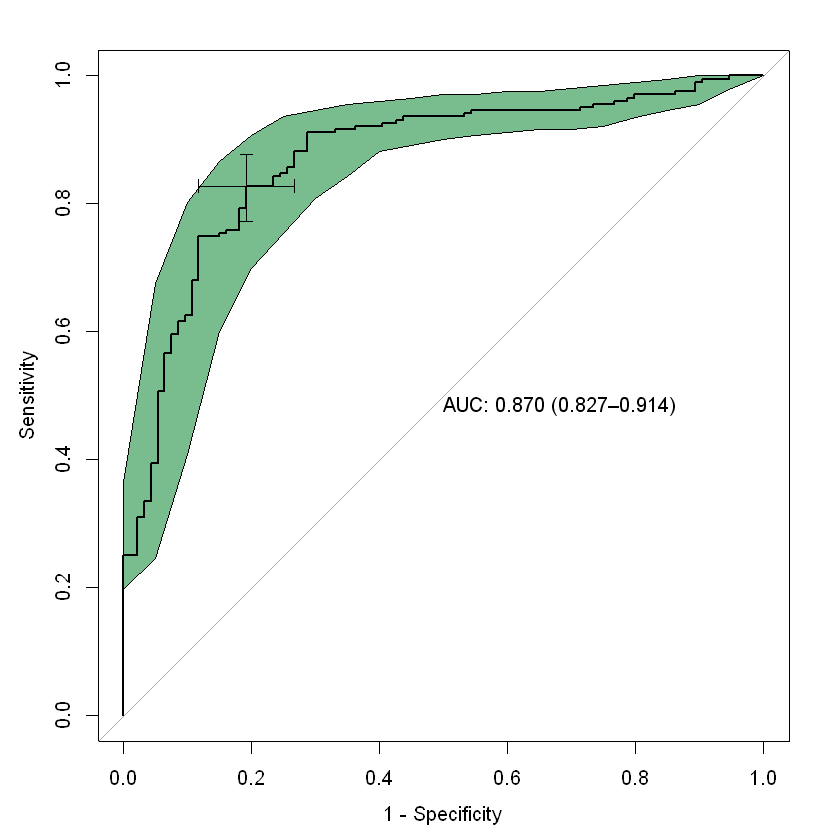

In [29]:
rocobj<-plot.roc(TestActual, predmodL1.1, print.thres = F, print.auc = T, legacy.axes = T,
                 main="", percent=F,
                 ci=TRUE)
ciobj<-ci.se(rocobj, specificities = seq(0,1,.05))

plot(ciobj, type = "shape", col="#79BD8F")
plot(ci(rocobj, of = "thresholds", thresholds = "best"))

### Random Forests

In [30]:

fit<-randomForest(as.factor(train$FinalCourseGradeAB_Rest2) ~ 
                    P111LastGradeAB_Rest  +
                    P111WVUCount  +
                    P112FirstAttempt  +
                    CURGPA  +
                    HSGPA  +
                    ACTSATM + 
                    ACTSATV +
                    Cal1LastGradeAB_Rest +
                    Cal1WVUCount +
                    CUREnroll +
                    CURAZcount  +
                    APCount + 
                    APCredit  +
                    IsFirstFall +
                    IsFirstGen +
                    MathEntry +
                    CURCMP +
                    GenderNum +
                    IsURM, data = train, importance = TRUE, ntree = 10000)


In [31]:
PredictionRandomF<-predict(fit, test)
pred<-predict(fit, newdata = test, type = 'prob')
confusionMatrix(PredictionRandomF, as.factor(test$FinalCourseGradeAB_Rest2))


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  63  22
         1  31 181
                                          
               Accuracy : 0.8215          
                 95% CI : (0.7732, 0.8634)
    No Information Rate : 0.6835          
    P-Value [Acc > NIR] : 5.523e-08       
                                          
                  Kappa : 0.5767          
 Mcnemar's Test P-Value : 0.2718          
                                          
            Sensitivity : 0.6702          
            Specificity : 0.8916          
         Pos Pred Value : 0.7412          
         Neg Pred Value : 0.8538          
             Prevalence : 0.3165          
         Detection Rate : 0.2121          
   Detection Prevalence : 0.2862          
      Balanced Accuracy : 0.7809          
                                          
       'Positive' Class : 0               
                                          

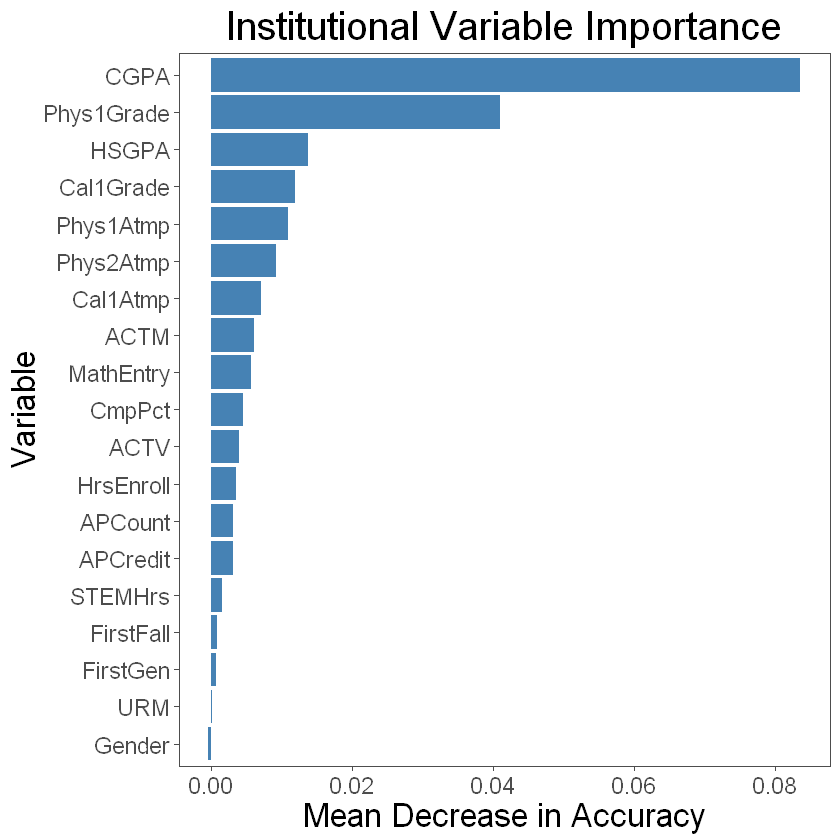

In [32]:
fitImp<-as.data.frame(fit[["importance"]])
fitImp$names<-c("Phys1Grade", "Phys1Atmp","Phys2Atmp","CGPA", "HSGPA",
                "ACTM", "ACTV", "Cal1Grade",
                "Cal1Atmp", "HrsEnroll", "STEMHrs",
                "APCount", "APCredit", "FirstFall", "FirstGen", "MathEntry",           
                "CmpPct","Gender","URM")

ggplot(fitImp, aes(x = reorder(names, MeanDecreaseAccuracy), y = MeanDecreaseAccuracy))+
  geom_bar(stat = "identity", fill = "steelblue") +
  ylab("Mean Decrease in Accuracy")+
  xlab("Variable")+
  ggtitle("Institutional Variable Importance") +
  coord_flip()+
  theme_few()+
  theme(plot.title = element_text(hjust = .5), axis.text = element_text(size = 14), text = element_text(size = 20))


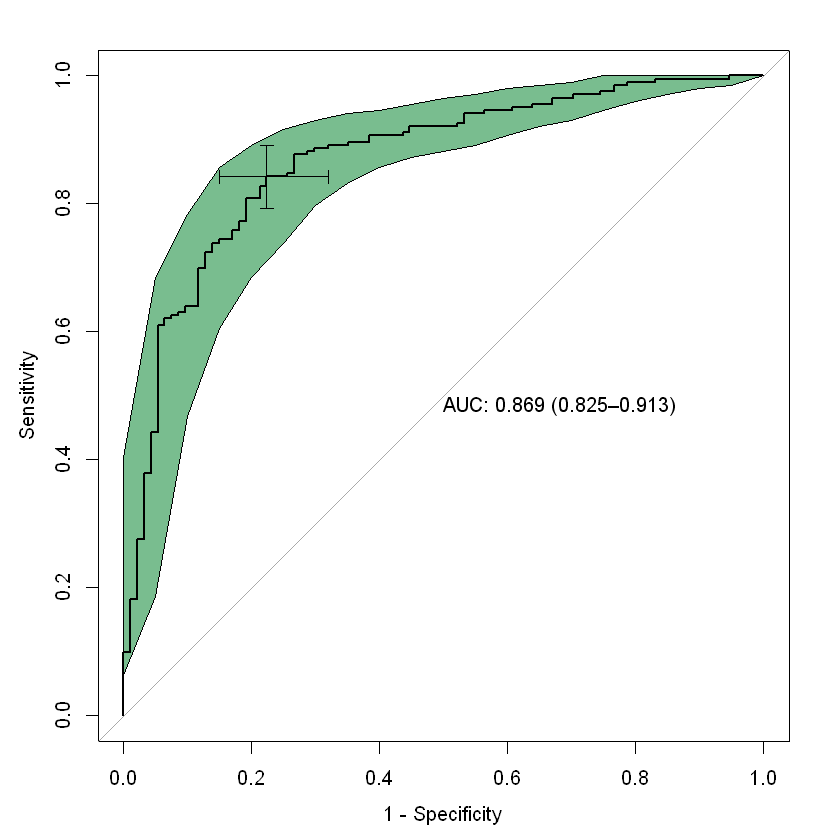

In [33]:
rocobjrf<-plot.roc(TestActual, pred[,2], print.thres = F, print.auc = T, legacy.axes = T,
                 main="", percent=F,
                 ci=TRUE)
ciobjrf<-ci.se(rocobjrf, specificities = seq(0,1,.05))

plot(ciobjrf, type = "shape", col="#79BD8F")
plot(ci(rocobjrf, of = "thresholds", thresholds = "best"))

#### Selecting the Most Parsimonious Model

##### 1-SE rule

In [34]:
fit2<-varSelRF(train[,c("P111LastGradeAB_Rest" , "P111WVUCount" , "P112FirstAttempt" ,"CURGPA" , "HSGPA" , "ACTSATM",
                        "ACTSATV","Cal1LastGradeAB_Rest","Cal1WVUCount","CUREnroll","CURAZcount","CURCred","APCount",
                        "APCredit","TransferCount","TransferCredit","IsFirstFall","IsFirstGen","MathEntry","CURCMP","GenderNum","IsURM" )],
               as.factor(train$FinalCourseGradeAB_Rest2), ntree = 10000, c.sd = 1)
fit2$selected.model

[1] "Cal1LastGradeAB_Rest + CURCred + CURGPA + HSGPA + P111LastGradeAB_Rest"

In [35]:
fit2.1<-randomForest(as.factor(train$FinalCourseGradeAB_Rest2) ~ 
                            Cal1LastGradeAB_Rest + CURCred + CURGPA + HSGPA + P111LastGradeAB_Rest + P111WVUCount
                          , data = train, importance = TRUE, ntree = 10000)


In [36]:
PredictionRandomF<-predict(fit2.1, test)
pred<-predict(fit2.1, newdata = test, type = 'prob')
confusionMatrix(PredictionRandomF, as.factor(test$FinalCourseGradeAB_Rest2))


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  64  24
         1  30 179
                                          
               Accuracy : 0.8182          
                 95% CI : (0.7695, 0.8604)
    No Information Rate : 0.6835          
    P-Value [Acc > NIR] : 1.178e-07       
                                          
                  Kappa : 0.5724          
 Mcnemar's Test P-Value : 0.4962          
                                          
            Sensitivity : 0.6809          
            Specificity : 0.8818          
         Pos Pred Value : 0.7273          
         Neg Pred Value : 0.8565          
             Prevalence : 0.3165          
         Detection Rate : 0.2155          
   Detection Prevalence : 0.2963          
      Balanced Accuracy : 0.7813          
                                          
       'Positive' Class : 0               
                                          

In [37]:
roc.mod2<-roc(TestActual, pred[,2])
cat("AUC CI: ", ci.auc(roc.mod2),"\n")

AUC CI:  0.8068513 0.8539985 0.9011458 


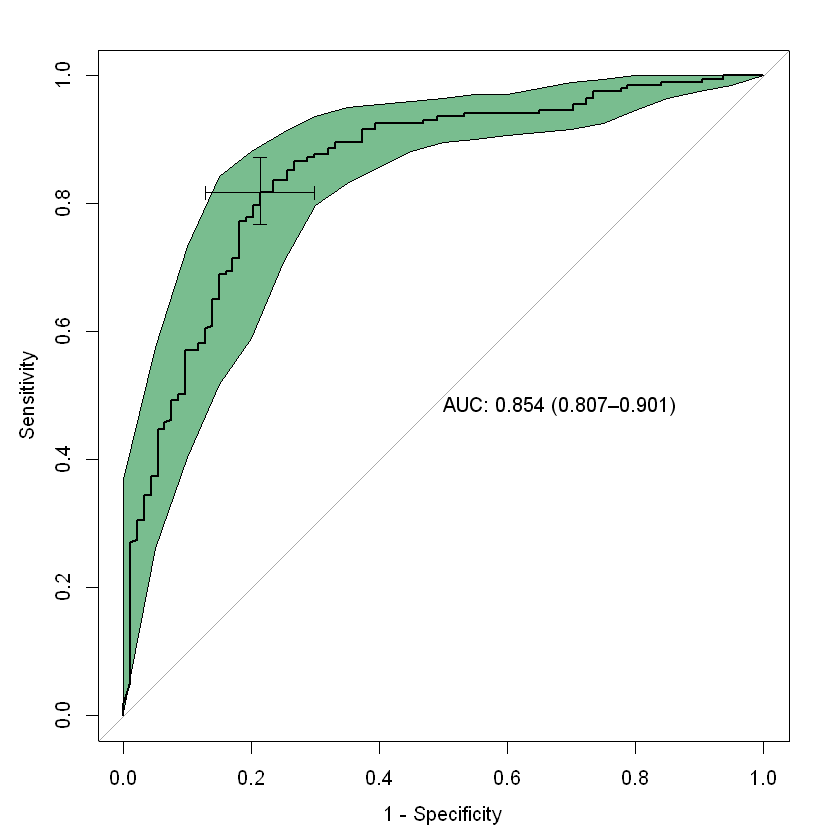

In [38]:
rocobjrf2<-plot.roc(TestActual, pred[,2], print.thres = F, print.auc = T, legacy.axes = T,
                 main="", percent=F,
                 ci=TRUE)
ciobjrf2<-ci.se(rocobjrf2, specificities = seq(0,1,.05))

plot(ciobjrf2, type = "shape", col="#79BD8F")
plot(ci(rocobjrf2, of = "thresholds", thresholds = "best"))

##### Researcher Intuition Model

In [39]:
fit2.2<-randomForest(as.factor(train$FinalCourseGradeAB_Rest2) ~ 
                            CURGPA + P111LastGradeAB_Rest
                          , data = train, importance = TRUE, ntree = 10000)

In [40]:
PredictionRandomF<-predict(fit2.2, test)
pred<-predict(fit2.2, newdata = test, type = 'prob')
confusionMatrix(PredictionRandomF, as.factor(test$FinalCourseGradeAB_Rest2))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  64  18
         1  30 185
                                          
               Accuracy : 0.8384          
                 95% CI : (0.7915, 0.8784)
    No Information Rate : 0.6835          
    P-Value [Acc > NIR] : 8.887e-10       
                                          
                  Kappa : 0.6132          
 Mcnemar's Test P-Value : 0.1124          
                                          
            Sensitivity : 0.6809          
            Specificity : 0.9113          
         Pos Pred Value : 0.7805          
         Neg Pred Value : 0.8605          
             Prevalence : 0.3165          
         Detection Rate : 0.2155          
   Detection Prevalence : 0.2761          
      Balanced Accuracy : 0.7961          
                                          
       'Positive' Class : 0               
                                          

In [41]:
roc.mod2.2<-roc(TestActual, pred[,2])
cat("AUC CI: ", ci.auc(roc.mod2.2),"\n")

AUC CI:  0.8295166 0.8736506 0.9177845 


#### Model Comparison

In [42]:
roc.test(roc.mod2, roc.mod2.2)


	DeLong's test for two correlated ROC curves

data:  roc.mod2 and roc.mod2.2
Z = -1.8639, p-value = 0.06234
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8539985   0.8736506 


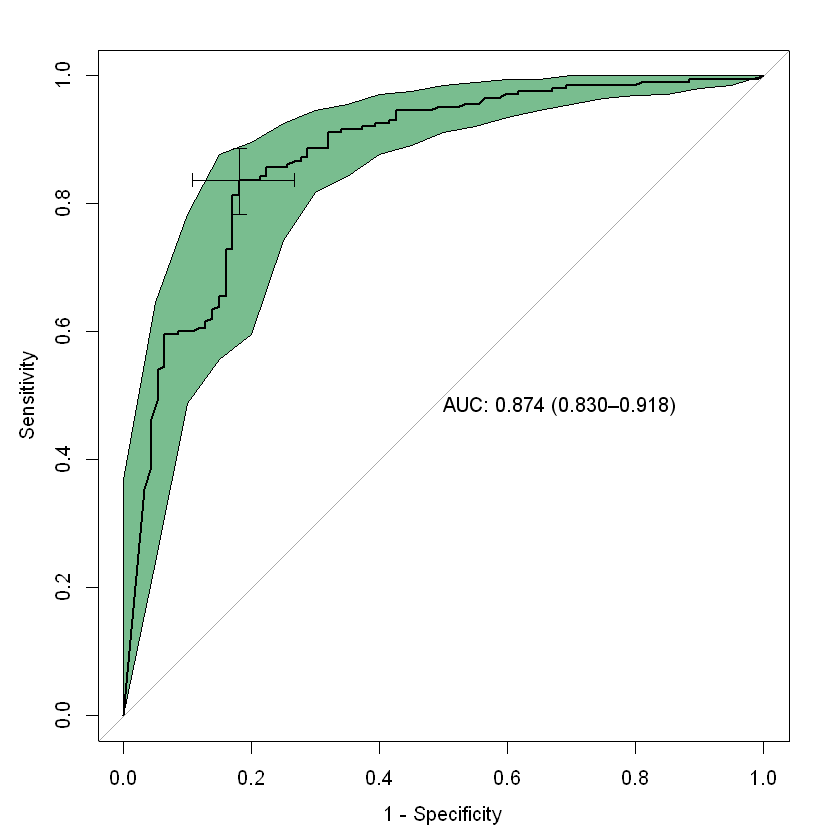

In [43]:
rocobjrf2.2<-plot.roc(TestActual, pred[,2], print.thres = F, print.auc = T, legacy.axes = T,
                 main="", percent=F,
                 ci=TRUE)
ciobjrf2.2<-ci.se(rocobjrf2.2, specificities = seq(0,1,.05))

plot(ciobjrf2.2, type = "shape", col="#79BD8F")
plot(ci(rocobjrf2.2, of = "thresholds", thresholds = "best"))

In [44]:
roc.test(roc.ModL1.1, roc.mod2)


	DeLong's test for two correlated ROC curves

data:  roc.ModL1.1 and roc.mod2
Z = 1.6903, p-value = 0.09098
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8701918   0.8539985 


In [45]:
roc.test(roc.ModL1.1, roc.mod2.2)


	DeLong's test for two correlated ROC curves

data:  roc.ModL1.1 and roc.mod2.2
Z = -0.3505, p-value = 0.726
alternative hypothesis: true difference in AUC is not equal to 0
sample estimates:
AUC of roc1 AUC of roc2 
  0.8701918   0.8736506 
